**Libraries**

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import keras
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict

**DQN Object**

In [25]:
class DQN():
    def __init__(self, observation_size, action_size, discount_factor, n_episodes, start_epsilon, end_epsilon, epsilon_decay, batch_size):
        #Observation and action space size
        self.observation_size = observation_size
        self.action_size = action_size

        #Q Learning members
        self.discount_factor = discount_factor
        self.n_episodes = n_episodes
        self.epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.epsilon_decay = epsilon_decay
        
        #replay memory members
        self.memory = deque(maxlen = 1000)
        self.batch_size = batch_size
        self.update_num = 50
        self.update_steps = 0

        #neural network members
        self.q_network = self.create_model()
        self.target_network = self.create_model()

    #will be a 4 layer NN, using MSE maybe Hubner, ReLu activations in each layer and Linear output to match nature of DQN
    def create_model(self):
        #input layer
        inputs = keras.Input(shape = (self.observation_size))
        #hidden layers using ReLu activation might mess with number of neurons
        layer_1 = keras.layers.Dense(64, activation = "relu")(inputs)
        layer_2 = keras.layers.Dense(64, activation = "relu")(layer_1)
        layer_3 = keras.layers.Dense(64, activation = "relu")(layer_2)
        #output layer, 2 neurons for corresponding actions, linear to preserve Q value
        outputs = keras.layers.Dense(action_size, activation = "linear")(layer_3)
        #building model
        model = keras.Model(inputs = inputs, outputs = outputs)
        model.compile(optimizer = "Adam", loss = "mse")
        return model

    #add to our experience replay
    def add_memory(self, curr_state, action, next_state, reward, truncated, terminated):
        self.memory.append([curr_state, action, next_state, reward, truncated, terminated])
    
    #epsilon greedy approach for an action
    def get_action(self, curr_state):
        if np.random.random() < self.epsilon:
            #random action
            print("Took random action")
            return env.action_space.sample()
        else:
            print("Took action from Q Network")
            #getting action from our q network with heighest Q value
            predicted_action = self.q_network.predict(curr_state, verbose = 0)
            #getting max value from our 1x2 np array
            return np.argmax(predicted_action[0])

    def choose_action(self, curr_state):
        predicted_action = self.q_network.predict(curr_state, verbose = 0)
        #getting max value from our 1x2 np array
        return np.argmax(predicted_action[0])
    
    #function to decay epsilon
    def decay_epsilon(self):
        self.epsilon = max(self.end_epsilon, self.epsilon - self.epsilon_decay)

    #function to train DQN
    def train(self):
        #don't use neural network if we don't have enough memory in our replay buffer
        #want to build up experience to train from
        if len(self.memory) < self.batch_size:
            print("Memory Size less than batch size, returning")
            return

        #copying weights from q network to target network
        if self.update_steps % self.update_num == 0:
            print("Copying weigths over")
            self.update_target()

        #getting values of next states from target networks, with Belleman Equation, 
        # then training Q Network with these values
        mini_batch = random.sample(self.memory, batch_size)
        for curr_state, action, next_state, reward, truncated, terminated in mini_batch:
            target = self.q_network.predict(curr_state, verbose = 0)
            if not truncated or terminated:
                target_q = self.target_network.predict(next_state, verbose = 0)[0]
                target[0][action] = reward + discount_factor * max(target_q)
            else:
                target[0][action] = reward
        
        print("Training Neural Network on Batch")
        #training model and decaying epsilon
        self.q_network.fit(curr_state, target, verbose = 0)
        self.decay_epsilon()
        self.update_steps += 1

    #function to update our target network with the weights of the q network
    def update_target(self):
        self.target_network.set_weights(self.q_network.get_weights())

    #methods to save model
    def save_model(self, file_name):
        self.q_network.save(file_name)
    
    #method to load model
    def load_model(self, file_name):
        self.q_network = keras.saving.load_model(file_name)
        self.target_network = keras.saving.load_model(file_name)


**HyperParamaters**

In [44]:
#initializing enviorment
#want to change Natural to True and to rerun model and save that new model
env = gym.make('Blackjack-v1', natural=True, sab=False)
env.reset()

#hyperparametrs and other members needed for our DQN Object
observation_size = len(env.observation_space)
action_size = env.action_space.n 
#these values can be tweaked to try and imporve performance
discount_factor = 0.95
n_episodes = 600 
start_epsilon = 1
end_epsilon =  0.01
epsilon_decay = 1e-3 
batch_size = 64
test_episodes = 8000

Intializing DQN Agent

In [34]:
agent = DQN(observation_size, action_size, discount_factor, n_episodes, start_epsilon, end_epsilon, epsilon_decay, batch_size)
#agent.load("file_name")

Summary of Q Network

In [35]:
#agent.q_network.summary()

Summary of Target Network

In [36]:
#agent.target_network.summary()

**Main Training Loop**

In [ ]:
#dictonary to store how many times agent wins vs dealer 
# in an episode to help visualize training
training_ratio = defaultdict(int)

for episode in range(n_episodes):
    curr_state,_ = env.reset()
    truncated = False
    terminated = False
    total_reward = 0

    #temp array to store wins and loss
    temp_ratio = [0,0]

    while not terminated or truncated:
        #reshape to a 1 by however many column's needed np array
        curr_state = np.array(curr_state).reshape(1,-1)
        action = agent.get_action(curr_state)

        #reshape next state to same shape as current state but in a different manor
        next_state, reward, terminated, truncated,_ = env.step(action) 
        next_state = np.reshape(next_state, [1, agent.observation_size])

        #add into our replay memory
        agent.add_memory(curr_state, action, next_state, reward, truncated, terminated)

        #train agent
        agent.train()

        curr_state = next_state
        total_reward += reward

        #getting amount of player vs dealer wins 
        if reward == 1:
            temp_ratio[0] +=1
        elif reward == -1:
            temp_ratio[1] += 1

    #appending totals for current episode
    training_ratio[episode] = temp_ratio
    
    print(f"Epsiode: {episode}, epsilon: {agent.epsilon}, total reward: {total_reward}")

Saving Model

In [ ]:
agent.save_model("Model_600_Episodes")

**Plotting Training Wins vs Losses**

In [ ]:
#unpacking our dictionary to plot
episode_values, values = zip(*training_ratio.items())
agent_wins, dealer_wins = zip(*values)

plt.figure(figsize=(25, 8))
plt.plot(episode_values, agent_wins, label ="Agent")
#plt.plot(episode_values, dealer_wins, label ='dealer_wins')


plt.xlabel("Episode")
plt.ylabel("Game Results (1 win, 0 loss)")
plt.legend()
#plt.title('Winner over time')
plt.show()


Dataframe for Plotting

In [61]:
df = pd.DataFrame(columns=['Agent Sum', 'Dealer Card', 'Agent Action', 'Agent Reward'])

Testing and Collecting Data

In [62]:
agent = DQN(observation_size, action_size, discount_factor, n_episodes, start_epsilon, end_epsilon, epsilon_decay, batch_size)
agent.load_model("Model_500_Episodes")

In [ ]:
for episode in range(test_episodes):
    curr_state, _ = env.reset()
    truncated = False
    terminated = False

    while not terminated or truncated:
        #reshape to a 1 by however many column's needed np array
        curr_state = np.array(curr_state).reshape(1,-1)
        action = agent.choose_action(curr_state)

        #reshape next state to same shape as current state but in a different manor
        next_state, reward, terminated, truncated,_ = env.step(action) 
        next_state = np.reshape(next_state, [1, agent.observation_size])

        #adding to our dataframe for plotting
        new_row = {'Agent Sum': curr_state[0][0], 'Dealer Card': curr_state[0][1], 'Agent Action': action, 'Agent Reward': reward}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        curr_state = next_state
        
    print(f"Epsiode: {episode}")
    

**Testing Results**

In [64]:
df["Action Label"] = df["Agent Action"].map({0: "Stick", 1: "Hit"})
df["Reward Label"] = df["Agent Reward"].map({-1: "Loss", 0: "Draw", 1: "Win", 1.5: "Win"})

df_test_results = df.drop_duplicates(subset=["Agent Sum", "Dealer Card"])
df_test_results.to_csv("Model_500_Test_Results", sep = ',')
df_test_results

,Agent Sum,Dealer Card,Agent Action,Agent Reward,Action Label,Reward Label
0,15,8,0,-1.0,Stick,Loss
1,15,5,0,1.0,Stick,Win
2,7,2,0,1.0,Stick,Win
3,17,5,0,-1.0,Stick,Loss
4,14,1,0,-1.0,Stick,Loss
...,...,...,...,...,...,...
3600,4,3,1,0.0,Hit,Draw
3774,5,1,0,1.0,Stick,Win
4281,4,8,1,0.0,Hit,Draw
4317,4,1,0,-1.0,Stick,Loss


**Winning Percentages**

In [65]:
agent_wins = df_test_results["Reward Label"].value_counts()["Win"]
dealer_wins = df_test_results["Reward Label"].value_counts()["Loss"]
draw_count = df_test_results["Reward Label"].value_counts()["Draw"]
total_games = agent_wins + dealer_wins + draw_count

agent_win_prct = (agent_wins / total_games) * 100
dealer_win_prct = (dealer_wins / total_games) * 100 
draw_prct = (draw_count / total_games) * 100

df_win_prct = pd.DataFrame(columns=["Agent Win Percentage", "Dealer Win Percentage", "Draw Percentage"])
new_row = {'Agent Win Percentage': agent_win_prct, 'Dealer Win Percentage': dealer_win_prct, 'Draw Percentage': draw_prct}
df_win_prct = pd.concat([df_win_prct, pd.DataFrame([new_row])], ignore_index=True)
df_win_prct


,Agent Win Percentage,Dealer Win Percentage,Draw Percentage
0,31.666667,40.555556,27.777778


Saving Winning Percentages

In [66]:
#don't forget to change name when saving
df_win_prct.to_csv("Model_500_Win_Percentage", sep = ',')

**Scatter Plot of Policy**

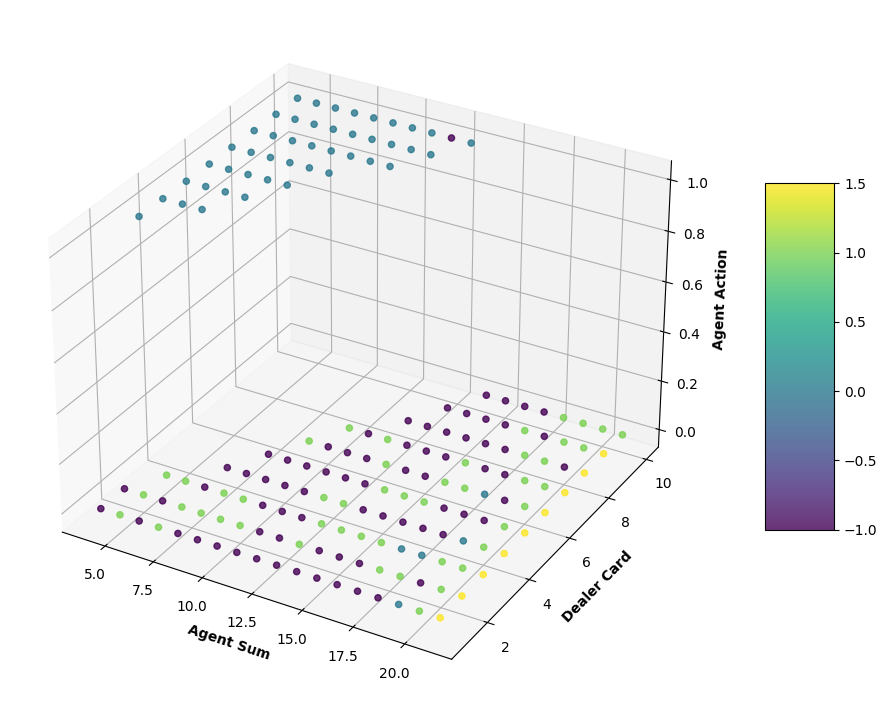

In [67]:
x = df_test_results["Agent Sum"]
y = df_test_results["Dealer Card"]
z = df_test_results["Agent Action"]
c = df_test_results["Agent Reward"]

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

sctt = ax.scatter3D(x, y, z, alpha = 0.8, c = c)

ax.set_xlabel("Agent Sum", fontweight ='bold') 
ax.set_ylabel("Dealer Card", fontweight ='bold') 
ax.set_zlabel("Agent Action", fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

**Heat Map of Policy**

In [68]:
fig = go.Figure(data=go.Heatmap(
    x=df_test_results["Agent Sum"],
    y=df_test_results["Dealer Card"],
    z=df_test_results["Agent Action"],
    colorscale="Viridis",
    colorbar=dict(title="Action"),
    hoverongaps=True,
    opacity = 0.75

))

fig.update_layout(
    xaxis=dict(title="Agent Sum", showgrid=True, dtick=1),
    yaxis=dict(title="Dealer Card", showgrid=True, dtick=1),
    xaxis_side="bottom"
)

fig.show()